In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import pi
from matplotlib import cycler
import matplotlib as mpl
plt.style.use('seaborn')

In [182]:
#----------------------------------------------------
# For FYS-2018 lab 1 you have to change this parameters
# as instructed in the assignment.
#----------------------------------------------------

## Parameters
D  = 0.6     # diffusivity for heat transport (W/m^2/K). Default = 0.6
A  = 191     # OLR when T = 0 (W/m^2). Default = 191
B  = 2.1     # OLR temperature dependence (W/m^2/K). Default = 2.1
cw = 9.8     # ocean mixed layer heat capacity (W/m^2*yr/K). Default = 9.8
S0 = 415     # insolation at equator (W/m^2). Default = 415
S2 = 240     # insolation spatial variation (W/m^2). Default = 240
a0 = 0.7     # ice-free co-albedo at equator. Default = 0.7
a2 = 0.1     # ice-free co-albedo spatial variation. Default = 0.1
ai = 0.4     # co-albedo where there is sea ice. Default = 0.4
F  = 4       # radiative forcing (W/m^2). Default = 0
tF = 15       # year of begin forcing. Default = 1
Nyears = 30  # number of simulation years. Default = 20
Tst= 10      # initial temperatur at all latitudes (dg C). Default = 10

#--------------------------------------
# For the first lab in FYS-2018 you do
# not have to change anything below this line
#--------------------------------------

In [183]:
## Input arrays
n  = 50             # grid resolution (number of points between equator and pole)
x  = np.linspace(0,1,n)
dx = 1/(n-1)
S  = S0-S2*(x**2)     # insolation [eq. (4) in WE14]
T0 = Tst*np.ones(n)  # initial condition (constant temperature 10C everywhere)
tspan = np.linspace(0,Nyears,Nyears+1) # timespan in years [t_start t_end]

# Cosmetics, you do not have to change these,
# but you can without breaking the script

plot = True #Determine whether or not to generate plots
fsize = [7.5,7.5] #Size of figures in inches
color = plt.cm.Spectral(np.linspace(0, 1,n))
mpl.rcParams['axes.prop_cycle'] = cycler('color', color)


In [184]:
#Right hand side of the ODE with a finite difference approximation
#for the spatial derivatives
def f(t,T):
    """
    Right hand side of the ODE with a finite difference approximation
    for the spatial derivatives
    """
    #Initialization of array
    Tdot = np.zeros(n)
    #Forcing
    alpha = (a0-a2*x**2)*np.where(T>0,1,0)+ ai*np.where(T<0,1,0)
    if t>tF:
        Fx = F
    else:
        Fx = 0

    C = alpha*S - A +Fx
    #Finite difference approximation for the meridional energy transport
    Tdot[1:-1] = ((D/(dx**2))*(1-x[1:-1]**2))*(T[2:] - 2*T[1:-1] + T[:-2]) - ((D*x[1:-1]/dx))*(T[2:] - T[:-2])
    Tdot[0] = D*(2*(T[1]-T[0])/(dx**2))
    Tdot[-1] = -D*(2*x[-1]*(T[-1]-T[-2]))/dx
    #Right hand side of the differential equation
    dTdt = (Tdot + C - B*T)/cw
    return dTdt


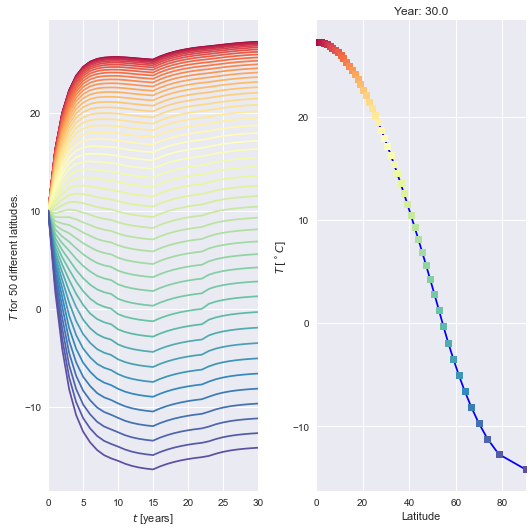

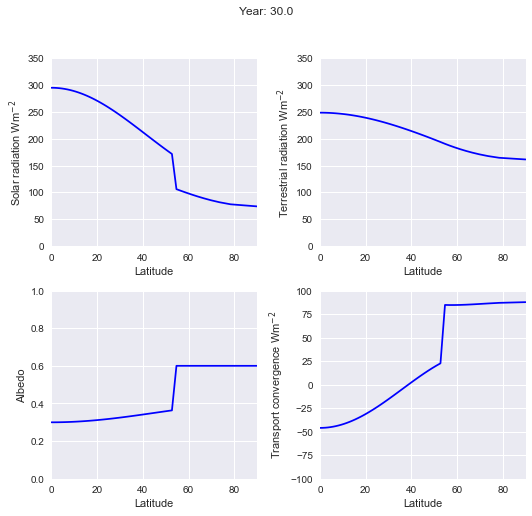

In [185]:
##Solution of problem
sol = solve_ivp(f,[0,Nyears],T0,t_eval = tspan,method = 'Radau')
tend = tspan[-1]
Tend = sol.y.T[-1,:]

##Albedo
albedo = 1 -((a0-a2*x**2)*np.where(Tend>0,1,0)+ ai*np.where(Tend<0,1,0))
## Radiation in and up and down
LL = (A + B*Tend)
LS = (1-albedo)*S + F

## Meridional enegy transport
Et = np.zeros(n)
Et[1:-1] = ((D/(dx**2))*(1-x[1:-1]**2))*(Tend[2:] - 2*Tend[1:-1] + Tend[:-2]) - ((D*x[1:-1]/dx))*(Tend[2:] - Tend[:-2])
Et[0] = D*(2*(Tend[1]-Tend[0])/(dx**2))
Et[-1] = -D*(2*x[-1]*(Tend[-1]-Tend[-2]))/dx
if plot:
    fig1,axs1 = plt.subplots(1,2)
    fig1.set_size_inches(fsize[0],fsize[1])

    #Plot of temperature for multiple latitudes as a funtion of time
    axs1[0].plot(sol.y.T)
    axs1[0].set_xlim([0,tend])
    axs1[0].set_ylabel(r'$T$ for ' + str(n) + ' different latitudes.')
    axs1[0].set_xlabel(r'$t$ [years]')
    #Plot of temperature at the end of simulation as a fuction of latitude
    #Plot of temperature at the end of simulation as a fuction of latitude
    axs1[1].plot(np.arcsin(x)/pi*180,Tend,'b',markerfacecolor = 'none')
    x2 = np.arcsin(x)/pi*180
    for x_2,T_end in zip(x2, Tend):
        plt.plot(x_2,T_end,'s')
    axs1[1].set_xlim([0,90])
    axs1[1].set_xlabel('Latitude')
    axs1[1].set_ylabel(r'$T \, [^\circ C]$ ')
    axs1[1].set_title('Year: ' + str(tend))
    plt.tight_layout()

    fig2,axs2 = plt.subplots(2,2)
    fig2.set_size_inches(fsize[0],fsize[1])
    fig2.suptitle('Year: ' + str(tend))
    #Solar radiation at the end of simulation
    axs2[0,0].plot(np.arcsin(x)/pi*180,LS,'b')
    axs2[0,0].set_ylim([0,350])
    axs2[0,0].set_xlim([0,90])
    axs2[0,0].set_xlabel('Latitude')
    axs2[0,0].set_ylabel(r'Solar radiation Wm$^{-2}$')

    #Terrestrial radiation at the end of simulation
    axs2[0,1].plot(np.arcsin(x)/pi*180,LL,'b')
    axs2[0,1].set_ylim([0,350])
    axs2[0,1].set_xlim([0,90])
    axs2[0,1].set_xlabel('Latitude')
    axs2[0,1].set_ylabel(r'Terrestrial radiation Wm$^{-2}$')

    #Albedo
    axs2[1,0].plot(np.arcsin(x)/pi*180,albedo,'b')
    axs2[1,0].set_ylim([0,1])
    axs2[1,0].set_xlim([0,90])
    axs2[1,0].set_xlabel('Latitude')
    axs2[1,0].set_ylabel('Albedo')

    #Transport convergence
    axs2[1,1].plot(np.arcsin(x)/pi*180,Et,'b')
    axs2[1,1].set_ylim([-100,100])
    axs2[1,1].set_xlim([0,90])
    axs2[1,1].set_xlabel('Latitude')
    axs2[1,1].set_ylabel(r'Transport convergence Wm$^{-2}$')
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

In [186]:
print("""
===================================
Global mean temperature at year """ + str(Nyears) + ': \n' + str(np.round(np.mean(Tend),4)) + """
=================================== """)

if plot:
    plt.show()


Global mean temperature at year 30: 
13.5712
